* Document length are much more evenly distributed than word total counts
* Anchor document assumption also seems to hold
* Can use fast clustering methods to somehow initialize?

* But anchor document may not be enough... each is still a sample of very sparse counts

In [1]:
import os
import sys
import pandas as pd
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import seaborn as sns
from matplotlib.colors import LogNorm
import pickle

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 
datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"

np.random.seed(123)

In [2]:
## load data
dataname = "sla"
k = 6
rate=3

datafile=f"{datadir}/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
X = fitted['X'].toarray()
L = fitted['Ltrue']
F = fitted['Ftrue']


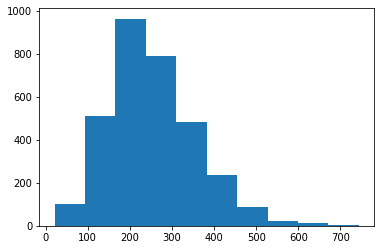

In [3]:
plt.hist(X.sum(axis = 1))
plt.show()

In [4]:
n, p = X.shape

## get true B,A

B = np.diag(X.sum(axis = 1)) @ L
cs = B.sum(axis = 0)
B /= cs

H = np.diag(cs) @ F.T
H /= H.sum(axis = 0)
A = H @ H.T / p

# DD = (np.diag(X.sum(axis = 1)) @ L) @ F.T ## poisson means, n by p
# DD /= DD.sum(axis = 0) ## treat each word as generated from multinomial (Pi matrix) 
# DD = (DD @ DD.T) / p
DD = B @ A @ B.T
DD_bar = DD / DD.sum(axis = 1)[:, None]
DD_bar_pca = Cbar_proj(DD)

In [5]:
%%capture
S0, B0, A0, _, _, _, _, _ = factorizeC(DD, K=k, rectifier='no', optimizer='activeSet')

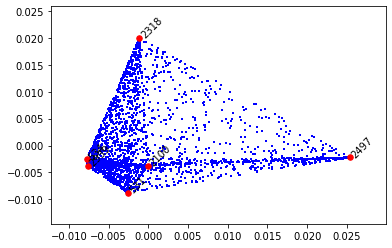

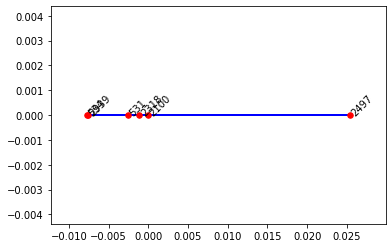

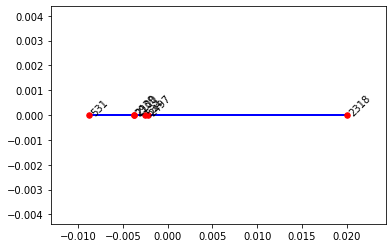

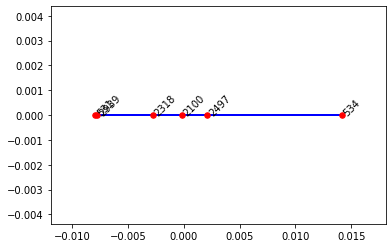

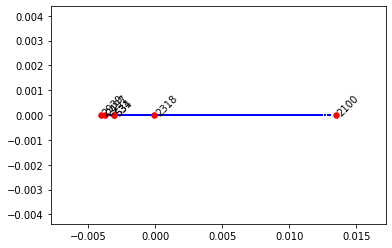

In [7]:
vis_extremal_pca(DD_bar_pca, S0, [0, 1], annotate=True, fontsize=10)

vis_extremal_pca(DD_bar_pca, S0, [0, 5], annotate=True, fontsize=10)
vis_extremal_pca(DD_bar_pca, S0, [1, 5], annotate=True, fontsize=10)
vis_extremal_pca(DD_bar_pca, S0, [3, 5], annotate=True, fontsize=10)
vis_extremal_pca(DD_bar_pca, S0, [4, 5], annotate=True, fontsize=10)

In [8]:
match_topics(B, B0).astype(int)

array([4, 2, 5, 3, 1, 0])

## Fit with naive DD

In [9]:
Pi_naive = X / X.sum(axis = 0)
DD_naive = Pi_naive @ Pi_naive.T / p
DD_naive_bar = DD_naive / DD_naive.sum(axis = 1)[:, None]
DD_naive_bar_pca = Cbar_proj(DD_naive)

In [10]:
%%capture
S1, B1, A1, _, _, _, _, _ = factorizeC(DD_naive, K=k, rectifier='no', optimizer='activeSet')

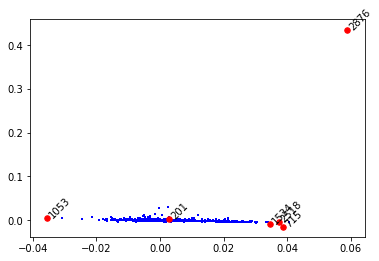

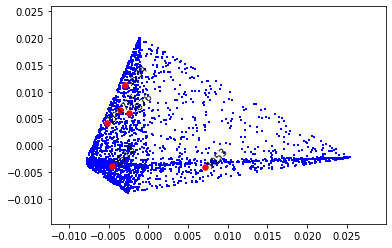

In [11]:
vis_extremal_pca(DD_naive_bar_pca, S1, [2, 3], annotate=True, fontsize=10)

vis_extremal_pca(DD_bar_pca, S1, [0, 1], annotate=True, fontsize=10)


# vis_extremal_pca(DD_naive_bar_pca, S1, [0, 5], annotate=True, fontsize=10)
# vis_extremal_pca(DD_naive_bar_pca, S1, [1, 5], annotate=True, fontsize=10)
# vis_extremal_pca(DD_naive_bar_pca, S1, [3, 5], annotate=True, fontsize=10)
# vis_extremal_pca(DD_naive_bar_pca, S1, [4, 5], annotate=True, fontsize=10)

Need to remove some outliers in naive DD. Below I project naive DD to the first PC components of true DD. 

In [12]:
pca = PCA(n_components=10)
pca.fit(DD_bar)
DD_naive_bar_pj= pca.transform(DD_naive_bar)

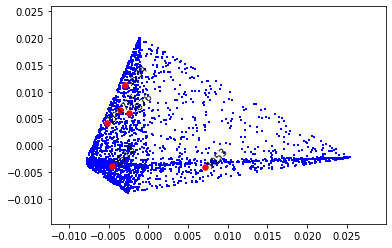

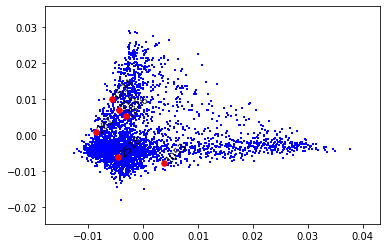

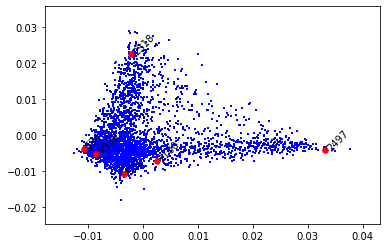

In [13]:
vis_extremal_pca(DD_bar_pca, S1, [0, 1], annotate=True, fontsize=10)

vis_extremal_pca(DD_naive_bar_pj, S1, [0, 1], annotate=True, fontsize=10)

vis_extremal_pca(DD_naive_bar_pj, S0, [0, 1], annotate=True, fontsize=10)



Suppose we have the right projection; then we can get extremal points just by taking the extremal points in each direction. Then we can see they are indeed "achor" like in the true DD matrix, except for a few. 

In [14]:
S2 = np.apply_along_axis(np.argmax, 0, DD_naive_bar_pj)
S2 = np.append(S2, np.apply_along_axis(np.argmin, 0, DD_naive_bar_pj))
S2

array([2564, 2433,  728,   99, 1093, 2672, 2340, 2732, 2564, 2089,  187,
        728, 2911,  728,  603, 1395, 2518, 2564, 1945, 1866])

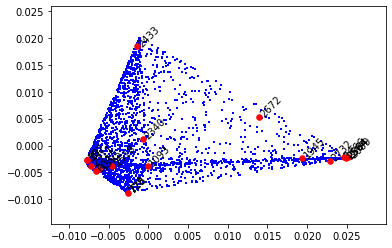

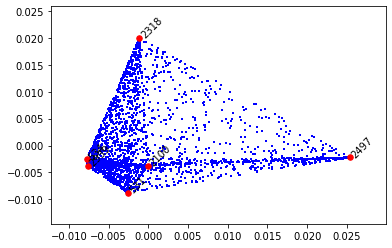

In [15]:
vis_extremal_pca(DD_bar_pca, S2, [0, 1], annotate=True, fontsize=10)

vis_extremal_pca(DD_bar_pca, S0, [0, 1], annotate=True, fontsize=10)



## Comment:

So now the key is, can we get correct estimate of right singular vectors? (many theories for that)

## Remove outliers

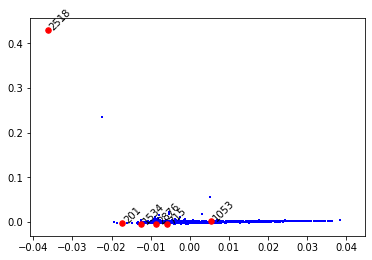

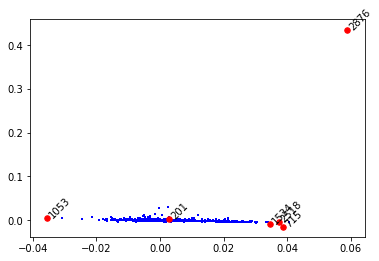

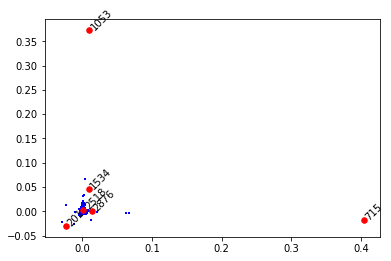

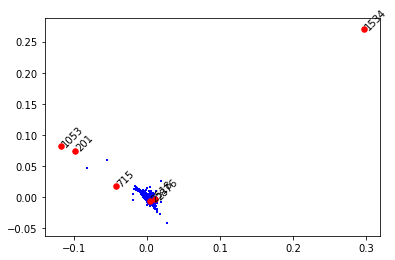

In [17]:
vis_extremal_pca(DD_naive_bar_pca, S1, [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(DD_naive_bar_pca, S1, [2, 3], annotate=True, fontsize=10)
vis_extremal_pca(DD_naive_bar_pca, S1, [4, 5], annotate=True, fontsize=10)
vis_extremal_pca(DD_naive_bar_pca, S1, [6, 7], annotate=True, fontsize=10)




